# Understanding the impact of EllSigmaPrior on Flux likelihood P(F|z, z_i, F_i)

## Calculated using the iteration process as described in Appendix A of 1612.00847

### Python version

#### Initialisation - for only 1 galaxy z_i, F_i

In [1]:
import sys
sys.path.append('../')
import numpy as np
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
from delight.utils_cy import approx_flux_likelihood_cy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import logging
import coloredlogs
import os
from time import time

# Plot formatting
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
paramFileName = 'tmp/parametersTest_11.cfg'
params = parseParamFile(paramFileName, verbose=False)

In [3]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
numZ = redshiftGrid.size

# Locate which columns of the catalog correspond to which bands.

bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="target_")

dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']

# f_mod  : flux model in each band as a function of the sed and the band name
# axis 0 : redshifts
# axis 1 : sed names
# axis 2 : band names

f_mod = np.zeros((redshiftGrid.size, len(sed_names),len(params['bandNames'])))
print(f_mod.shape)
print(sed_names)

(300, 8, 6)
['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'Im_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']


In [4]:
# loop on SED to load the flux-redshift file from the training
# ture data or simulated by simulateWithSEDs.py

for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')
print(f_mod[0, 0, :])

[0.06077789 0.26686768 0.51198425 0.71546947 0.86408203 0.96321689]


Number of targets : 415
0 0.89319359882774 [0 1 2 3 4 5]
f_mod is of dimensions (300, 8, 6)


/tmp/ipykernel_7909/481081529.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)
ellML is of dimensions (300, 8, 1)


/tmp/ipykernel_7909/481081529.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


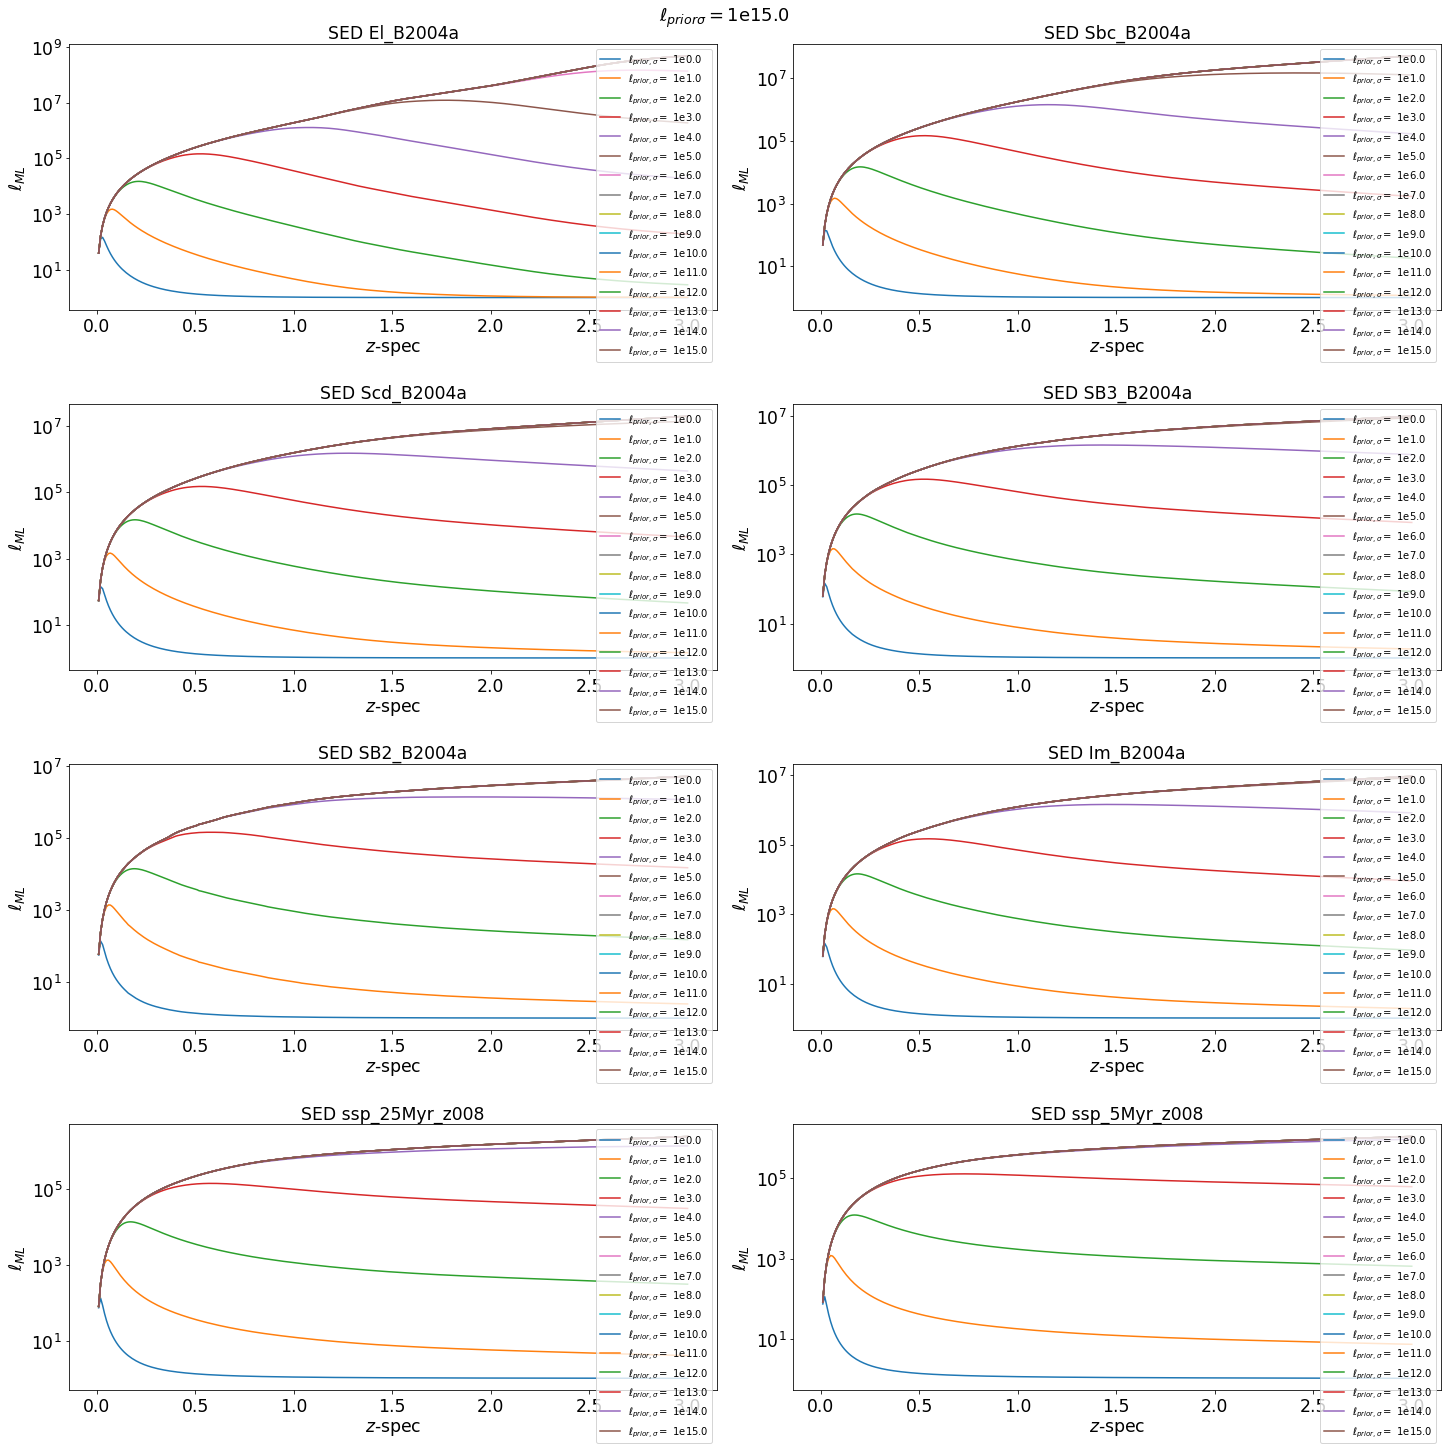

In [5]:
numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))
print("Number of targets : {}".format(numObjectsTarget))

firstLine = 0
lastLine = numObjectsTarget
numLines = lastLine - firstLine

# Now loop over each target galaxy (indexed bu loc index) to compute likelihood function
# with its flux in each bands
targetDataIter = getDataFromFile(params, firstLine, lastLine, prefix="target_", getXY=False)

loc, (z, normedRefFlux, bands, fluxes, fluxesVar, bCV, fCV, fvCV) = list(enumerate(targetDataIter))[0]
print(loc, z, bands)

print("f_mod is of dimensions {}".format(f_mod.shape))

fig, axs = plt.subplots(4, 2, constrained_layout=True)
sigmaList=np.logspace(0, 15, 16)
ell_hat_z = 1
sigmaIter=-1

for ellPriorSigma in sigmaList:
    sigmaIter+=1
    # approximate flux likelihood, with scaling of both the mean and variance.
    # This approximates the true likelihood with an iterative scheme.
    # - data : fluxes, fluxesVar
    # - model based on SED : f_mod

    ellML = approx_flux_likelihood(fluxes, fluxesVar, f_mod, normalized=True, marginalizeEll=True, returnEllML=True, ell_hat=ell_hat_z, ell_var=(ell_hat_z*ellPriorSigma)**2)

    ## Plot for this iteration on ellPriorSigma:
    alpha = 0.9
    s = 5
    plotInd = -1
    for ligne in np.arange(4):
        for colonne in np.arange(2):
            plotInd += 1
            axs[ligne, colonne].plot(redshiftGrid, ellML[:, plotInd, 0], label='$\ell_{prior, \sigma} =$'+' 1e{}'.format(np.log10(ellPriorSigma)))
            axs[ligne, colonne].set_xlabel('$z$-spec')
            axs[ligne, colonne].set_ylabel('$\ell_{ML}$')
            axs[ligne, colonne].set_yscale('log')
            axs[ligne, colonne].set_title('SED {}'.format(sed_names[plotInd]))
            axs[ligne, colonne].legend(loc="upper right")

    print("ellML is of dimensions {}".format(ellML.shape))

fig.suptitle('$\ell_{prior \sigma} = $'+'1e{}'.format(np.log10(ellPriorSigma)), fontsize=18,y=1.01)
fig.show()